# SBINN training with simulated data and importance sampling


This notebook contains the code to train an SBINN model using simulated data. In particular, it implements various methods to improve the convergence of vanilla PINN/SBINN such as:
- the ReLoBRaLo model that forces each loss component to improve at the same pace by balancing loss terms relatively to their improvements from the start of the training. "Multi-Objective Loss Balancing for Physics-Informed Deep Learning" by R. Bischof and M. A. Kraus.
- a heuristic approach that attempt at estimating the scale of each loss component. The idea is to normalise each loss component by the average of this same loss component that has been monitored for 1000 past iterations. Furthermore, the trivial solution is penalised by adding a regularisation term that is the inverse of the standard deviation of the derivative of the neural network output.
- the importance sampling algorithm as introduced by Nabian et al. (2021) in "Efficient Training of Physics-Informed Neural Networks via Importance Sampling". This allows to improve the SBINN model convergence for challenging ODE system such as stiff systems or with regions of near discontinuity.

To test the approach, we used a theoretical biological model as well as its ODE system that was presented in Chapter 13: Parameter Estimation, Sloppiness, and Model Identifiability by Daniels et al. (2018) in "Quantitative Biology: Theory, Computational Methods, and Models" to simulate data. It describes a three tiers phosphorylation cascade with a negative feedback. The downstream element has a phosphatase activity and can inactivate the first kinase, negatively regulating the transmission of the signal.

In [1]:
# Import necessary packages and set the seed for reproducibility
from PIL import Image
import numpy as np
import random
import copy
import os
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
torch.manual_seed(123)

In [2]:
# Set the device
choice = "cpu"   # override gpu even if available
if torch.backends.mps.is_built() and torch.backends.mps.is_available() and choice != "cpu":
    device = torch.device("mps")
elif torch.cuda.is_available() and choice != "cpu":
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## SBINN setup

### Helper functions for plotting and saving model results

In [3]:
def plot_training_result(t, y, t_data, y_data, y_nn, epoch=None, title=None, ylim=None, labels=None):
    """ Plots the neural network function approximation during training.
    """
    plt.figure(figsize=(8,4))
    palette = sns.color_palette("husl", y.size(1))

    if labels is None:
        labels = ["" for i in range(y.size(1))]

    # Plot ground truth and NN prediction
    for i in range(y_nn.size(1)):
        if i == 0:
            plt.plot(t, y[:,i], color=palette[i], linewidth=5, alpha=0.2, label=f"{labels[i]} Ground truth")
            plt.plot(t, y_nn[:,i], color=palette[i], linewidth=2, alpha=0.8, label=f"{labels[i]} NN output")
            plt.xlabel("Time [s]")
            if title is not None:
                plt.title(title)
            if ylim is not None:
                plt.ylim(ylim)
        else:
            plt.plot(t, y[:,i], color=palette[i], linewidth=5, alpha=0.2, label=f"{labels[i]} Ground truth")
            plt.plot(t, y_nn[:,i], color=palette[i], linewidth=2, alpha=0.8, label=f"{labels[i]} NN output")

    # Plot training data
    for i in range(y_data.size(1)):
        if i == 0:
            plt.scatter(t_data, y_data[:,0], s=50, color="black", label='Simulated data')
        else:
            plt.scatter(t_data, y_data[:,i], s=50, color="black")

    # Remove spines
    ax = plt.gca()
    ax.spines[["top", "right"]].set_visible(False)

    # Plot legend
    plt.legend(bbox_to_anchor =(1.4, 0.5), loc="center right", frameon=False, fontsize="medium", 
        title=f"Epochs: {epoch}", title_fontsize="large") 

In [8]:
def plot_losses(losses, weights, filename=None, labels=None):

    palette = sns.color_palette("husl", weights["Physics"].size(0))

    nb_plots = 1 + len(weights["Physics"]) 
    fig, axs = plt.subplots(nb_plots, 1, sharex=True, figsize=(6, 8), tight_layout=True)
    
    i = 0
    for name in losses:
        if torch.is_tensor(weights[name]):
            for j in range(len(weights[name])):
                loss = np.array(losses[name][j])
                axs[i].plot(np.log10(loss), color=palette[j], label=f"{name} Log10Loss ({labels[j]})", alpha=0.8)
                axs[i].set_ylabel("LogLoss")
                axs[i].spines["top"].set_visible(False)
                ax2 = axs[i].twinx()
                ax2.plot(np.log10(loss*weights[name][j].cpu().item()), color=palette[j])
                ax2.set_ylabel("Log10 Weighted Loss", rotation=270, labelpad=20)
                ax2.spines["top"].set_visible(False)
                i += 1
        else:
            loss = np.array(losses[name])
            axs[i].plot(np.log10(loss), color="black", label=name+" Log10Loss")
            axs[i].set_ylabel("LogLoss")
            axs[i].spines["top"].set_visible(False)
            ax2 = axs[i].twinx()
            ax2.plot(np.log10(loss*weights[name]), color="black")
            ax2.set_ylabel("Log10 Weighted Loss", rotation=270, labelpad=20)
            ax2.spines["top"].set_visible(False)
            i += 1
            
    fig.supxlabel('Epochs')
    plt.suptitle("Comparison of data and physics loss", y=1.02, fontsize="large")

    # Plot legend
    fig.legend(bbox_to_anchor =(1.4, 0.5), loc="center right", frameon=False, fontsize="medium", title_fontsize="large")

    if filename is not None:
        fig.savefig(filename, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")


In [9]:
def save_gif(outfile, images, fps=5, loop=0):
    """ Saves sequence of training plots as GIF image.
    """    
    # Open PIL images and delete original file
    for image in images:
        pil_imgs.append(Image.open(image).resize((930, 351)))
        os.remove(image)
    
    # Create GIF animation
    pil_imgs[0].save(fp=outfile, format='GIF', append_images=pil_imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [10]:
def save_video(outfile, images, fps=5, delete=False):
    """ Saves sequence of training plots as GIF image.
    """
    # Read the first image to get the dimensions
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 format
    video = cv2.VideoWriter(outfile, fourcc, fps, (width, height))  # FPS is set to 1 for demonstration

    for image in images:
        frame = cv2.imread(image)
        video.write(frame)
        if delete:
            os.remove(image)

    # Release the video writer object
    video.release()

    cv2.destroyAllWindows()

### ODE-specific functions 

In [11]:
def nfb_ode(t, y, param):
    """ Returns right hand size of the ODE system of NFB model upon signaling input.
    """
    if not torch.is_tensor(y):
        u = np.zeros((1, y.shape[0]))
        y = y.reshape(1, y.shape[0])
        if type(t) == float:
            t = np.array([t])
        
        # Define the light signal function
        signal_f = np.zeros((1, t.shape[0]))
        assert len(param["sig_on"]) == len(param["sig_off"])
        for i in range(len(param["sig_on"])):
            signal_f += ((np.tanh(100 * (t-param["sig_on"][i]))/2 - 
                          np.tanh(100 * (t-param["sig_off"][i]))/2))
    else:
        u = torch.zeros_like(y)
        
        # Define the light signal function
        signal_f = torch.zeros_like(t)
        assert len(param["sig_on"]) == len(param["sig_off"])
        for i in range(len(param["sig_on"])):
            signal_f += ((torch.tanh(100 * (t-param["sig_on"][i]))/2 - 
                          torch.tanh(100 * (t-param["sig_off"][i]))/2))

    # Compute right hand side of ODE system
    u[:,0] = (param["v1"] * param["inCC"] * signal_f[:,0] * (1-y[:,0]) / (param["k1"] + (1-y[:,0])) -
              param["v2"] * y[:,0] * (1 + param["alpha"] * (y[:,2]-1)) / (param["k2"] + y[:,0]))
    u[:,1] = (param["v3"] * y[:,0] * (1-y[:,1]) / (param["k3"] + (1-y[:,1])) -
              param["v4"] * y[:,1] * (1 + param["beta"] * (y[:,2]-1)) / (param["k4"] + y[:,1]))
    u[:,2] = (param["v5"] * y[:,1] * (1-y[:,2]) / (param["k5"] + (1-y[:,2])) -
              param["v6"] * y[:,2] / (param["k6"] + y[:,2]))
    
    return u # torch.tensor(u)

In [12]:
def nfb_residuals(t_minibatch, yhp, param, save_graph=True):
    """ Returns the ODE residuals of the NFB ODE system upon signal input for the 
    physics loss computation during SBINN training.
    """
    
    # Derive the first derivative of the ODE wrt sampled points
    dy = []
    for i in range(yhp.size(1)):  
        grad_output = torch.zeros_like(yhp)

        # Set the gradient output for the i-th dimension
        grad_output[:, i] = 1  
        grad = torch.autograd.grad(outputs=yhp, inputs=t_minibatch,
                                   grad_outputs=grad_output,
                                   create_graph=True)[0]
        dy.append(grad)
    dy = torch.stack(dy, dim=2).squeeze()
    dy_std = torch.var(dy, dim=0)

    # Compute the right hand side of the ODE system
    u = nfb_ode(t_minibatch, yhp.detach(), param)
    
    return dy - u, dy_std

In [13]:
def prot_activation_ode(t, y, param):
    """ Returns right hand size of the ODE system of protein activation upon signaling input.
    """
    # Define the light signal function
    signal_f = 0
    assert len(param["sig_on"]) == len(param["sig_off"])
    for i in range(len(param["sig_on"])):
        signal_f += ((np.tanh(100 * (t-param["sig_on"][i]))/2 - 
                      np.tanh(100 * (t-param["sig_off"][i]))/2))
    
    return (param["kinact"] * (param["p0"] * (1+signal_f) - y))

In [14]:
def prot_activation_residuals(t_minibatch, yhp, param, save_graph=True):
    """ Returns the ODE residuals of the protein activation system upon signal input for the 
    physics loss computation during SBINN training.
    """
    
    # Derive the first derivative of the ODE wrt sampled points
    dy = torch.autograd.grad(yhp, t_minibatch, torch.ones_like(yhp), create_graph=save_graph)[0]

    # Define the light signal function
    signal_f = 0
    assert len(param["sig_on"]) == len(param["sig_off"])
    for i in range(len(param["sig_on"])):
        signal_f += ((torch.tanh(100 * (t_minibatch-param["sig_on"][i]))/2 - 
                      torch.tanh(100 * (t_minibatch-param["sig_off"][i]))/2))
    
    return (dy - param["kinact"] * (param["p0"] * (1+signal_f) - yhp))

In [15]:
def prot_activation(param, t):
    """ Defines the analytical solution of the protein activation ODE. 
    """
    
    assert 0 < param["p0"]
    y  = param["p0"] * (1 - torch.exp(-param["kinact"] * t))
    
    return y

### Neural Network architecture

In [17]:
class FFN(nn.Module):
    """ Defines a feedforward fully connected network.
    """
    
    def __init__(self, in_dim, out_dim, h_dim, num_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(in_dim, h_dim),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(h_dim, h_dim),
                            activation()]) for _ in range(num_layers-1)])
        self.fce = nn.Linear(h_dim, out_dim)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        x = torch.sigmoid(x)
        return x

## SBINN Extensions

### Importance sampling algorithm

In [211]:
def importance_sampling(indices, seeds, ode_param, residuals_fn, model, space_size):
    """ Implements the importance sampling method from Nabian et al. (2021). The probability distribution of the sample
    domain is made proportional to the loss term. Elements of the sample space with higher loss have higher probability 
    to be sampled for the next minibatch.
    """
    # Determine physics loss at seed points
    yhp = model(seeds)
    physics, _ = residuals_fn(seeds, yhp, ode_param, save_graph=True)
    loss = torch.sum((physics.cpu())**2, dim=1)

    # Normalise the loss values so that they sum to one
    probabilities = loss / torch.sum(loss)

    # Cut the sample space into intervals centered around each each sample
    low_i = torch.zeros_like(indices)
    low_i[1:] = indices[0:-1] + (indices[1:]-indices[0:-1])/2

    up_i = torch.zeros_like(indices)
    up_i[0:-1] = low_i[1:]
    up_i[-1] = space_size

    intervals = (up_i-low_i)
    assert torch.sum(intervals) == space_size

    # Apply the estimated probability distribution to the intervals (~ nearest-neighbour)
    distribution = torch.repeat_interleave(probabilities, intervals)
    
    return distribution.detach()

### ReLoBRaLo algorithm

In [20]:
def update_relobralo_weight(losses, previous_w, temperature=1, 
                            decay_rate=0.9, bernoulli_rate=0.999):
    """ Updates the loss component weights according to the ReLoBRaLo method. 
    """
    # Define current loss using loss track array
    current_loss1 = torch.tensor(losses["Data"][-1]).view(-1,1)
    current_loss2 = torch.tensor([losses["Physics"][i][-1] for i in range(len(losses["Physics"]))]).view(-1,1)
    current_loss = torch.cat((current_loss1, current_loss2))

    # Define initial loss using loss track array
    start_loss1 = torch.tensor(losses["Data"][0]).view(-1,1)
    start_loss2 = torch.tensor([losses["Physics"][i][0] for i in range(len(losses["Physics"]))]).view(-1,1)
    start_loss = torch.cat((start_loss1, start_loss2))

    # Define previous loss using loss track array
    previous_loss1 = torch.tensor(losses["Data"][-2]).view(-1,1)
    previous_loss2 = torch.tensor([losses["Physics"][i][-2] for i in range(len(losses["Physics"]))]).view(-1,1)
    previous_loss = torch.cat((previous_loss1, previous_loss2))

    # Retrieve data and physics previous weights
    previous_w = torch.cat((torch.tensor(previous_w["Data"]).view(-1,1), previous_w["Physics"].view(-1,1)))

    # Sample Bernoulli variable
    rho = torch.bernoulli(torch.tensor(bernoulli_rate, dtype=torch.float))

    # Update weights according to ReLoBRaLo method
    intermediate_w0 = 2 * torch.nn.functional.softmax(torch.div(current_loss, start_loss * temperature + 1e-12),
                                                 dim=0)
    intermediate_w = 2 * torch.nn.functional.softmax(torch.div(current_loss, previous_loss * temperature + 1e-12),
                                                dim=0)
    lookback_w = rho * previous_w + (1-rho) * intermediate_w0
    updated_w = decay_rate * intermediate_w0 + (1-decay_rate) * intermediate_w 
    
    return {"Data": updated_w[0,0].item(), "Physics": updated_w[1:,0]}

### Loss Normalisation

In [21]:
def compute_loss_normalisation(loss1, loss2, weights, dy_std, threshold=1e-7):
    """ Computes the loss when normalising the loss components and 
    penalising the constant solution.
    """
    if torch.any(dy_std < threshold):
        return (weights["Data"] * loss1 + torch.sum(weights["Physics"] * loss2) + 
                torch.mean(1/(dy_std + 1e-12)))
            
    else:
        return (weights["Data"] * loss1 + torch.sum(weights["Physics"] * loss2))

In [22]:
def update_loss_statistics(losses, epoch):
    """ Updates the statistics (mean and std) about the loss over 1000 past epochs.
    """
    weights = {}
    loss_std = {}

    weights["Data"] = 1 / torch.mean(torch.tensor(losses["Data"][(epoch+1-1000):(epoch+1)])).item()        
    weights["Physics"] = torch.div(1, torch.tensor([
        torch.mean(torch.tensor(losses["Physics"][0][(epoch+1-1000):(epoch+1)])),
        torch.mean(torch.tensor(losses["Physics"][1][(epoch+1-1000):(epoch+1)])),
        torch.mean(torch.tensor(losses["Physics"][2][(epoch+1-1000):(epoch+1)]))]))

    loss_std["Data"] = torch.std(torch.tensor(losses["Data"][(epoch+1-1000):(epoch+1)])).item()
    loss_std["Physics"] = torch.tensor([
        torch.std(torch.tensor(losses["Physics"][0][(epoch+1-1000):(epoch+1)])),
        torch.std(torch.tensor(losses["Physics"][1][(epoch+1-1000):(epoch+1)])),
        torch.std(torch.tensor(losses["Physics"][2][(epoch+1-1000):(epoch+1)]))])

    return weights, loss_std

## Data Simulation

##### NFB ODE

In [23]:
nfb_param_a = {"v1": 0.5, "v2": 5, "v3": 5, "v4": 0.03, "v5": 0.1, "v6": 0.1,
            "k1": 0.1, "k2": 0.1, "k3": 0.1, "k4": 0.1, "k5": 1, "k6": 10,
            "alpha": 1, "beta": 0, "inCC": 0.01, "sig_on":[0], "sig_off": [100]}

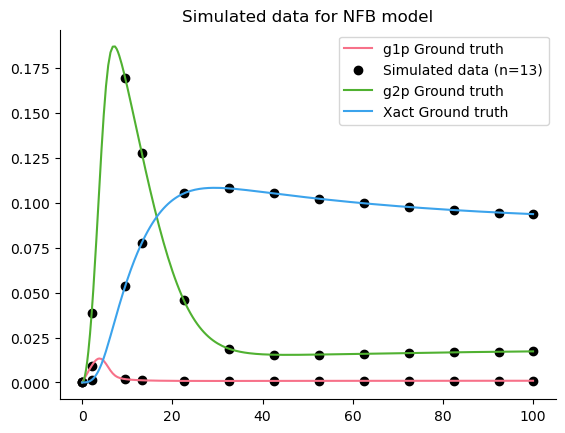

In [24]:
# Get the analytical solution over the full domain
nfb_ode_sol = scipy.integrate.solve_ivp(fun=nfb_ode, t_span=(0, 100), 
                              y0=np.zeros(3), 
                              method="LSODA",
                              max_step=0.5,
                              args=(nfb_param_a,))

nfb_t = torch.tensor(nfb_ode_sol.t[np.newaxis, :], dtype=torch.float).view(-1,1)
nfb_y = torch.transpose(torch.tensor(nfb_ode_sol.y), 0, 1)


# Slice out a small number of points from the LHS of the domain
nfb_t_data = nfb_t[::20,:] #[0:20:4]
nfb_y_data = nfb_y[::20,:] #[0:20:4]

# Plot training data
palette = sns.color_palette("husl", nfb_y.size(1))
labels = ["g1p", "g2p", "Xact"]
plt.figure()
for i in range(nfb_y.size(1)):
    plt.plot(nfb_ode_sol.t, nfb_ode_sol.y[i,:],
         label=f"{labels[i]} Ground truth", color=palette[i])
    if i == 0:
        plt.scatter(nfb_t_data, nfb_y_data[:,i], color="black", label=f"Simulated data (n={len(nfb_t_data)})")
    else:
        plt.scatter(nfb_t_data, nfb_y_data[:,i], color="black", label=f"")

plt.title("Simulated data for NFB model")
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)
plt.legend()
plt.show()

# Save simulated data
#torch.save({'t': nfb_t, 'y': nfb_y, 't_data': nfb_t_data, 'y_data': nfb_y_data}, './Data/nfba_13data_1pulse.pth')

##### Protein activation ODE

In [25]:
# Define ODE parameters
prot_activ_param = {"kinact": 0.034, "p0": 1, "sig_on":[10, 100], "sig_off": [11, 101]}

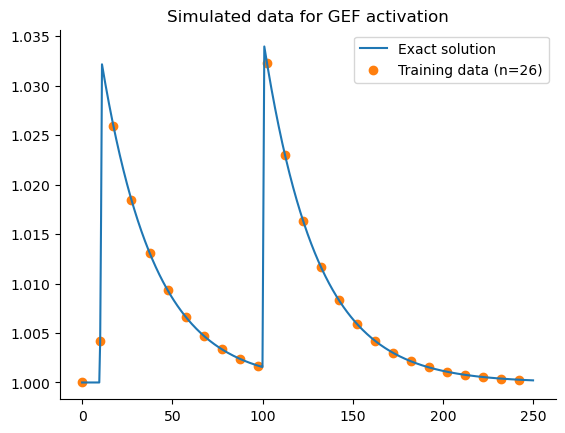

In [26]:
# Simulate data and plot exact solution over the full domain
prot_activ_ode_sol = scipy.integrate.solve_ivp(fun=prot_activation_ode, t_span=(0, 250), 
                              y0=np.array([1]), 
                              method="LSODA",
                              max_step=0.5,
                              args=(prot_activ_param,))
# Simulate data and plot exact solution over the full domain
prot_activ_t = torch.tensor(prot_activ_ode_sol.t, dtype=torch.float).view(-1,1)
prot_activ_y = torch.tensor(prot_activ_ode_sol.y.squeeze()).view(-1,1)

# Slice out a small number of points from the LHS of the domain
prot_activ_t_data = prot_activ_t[::20]#[0:20:4]
prot_activ_y_data = prot_activ_y[::20]#[0:20:4]

# Plot training data
plt.figure()
plt.plot(prot_activ_ode_sol.t, prot_activ_ode_sol.y.squeeze(), label="Exact solution")
plt.scatter(prot_activ_t_data, prot_activ_y_data, color="tab:orange", label=f"Training data (n={len(prot_activ_t_data)})")
plt.title("Simulated data for GEF activation")
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)
plt.legend()
plt.show()

## Train SBINN model

In [36]:
def train_sbinn(t_data, y_data, t, y, residuals_fn=None, ode_param=None, 
                plot_title="", ylim=None, labels=None, 
                size_batch=1000, size_space=int(1e4), n_epochs=int(1e4),
                early_stop_patience=1000, lr_patience=1000, algorithms=[]):

    # Define model and ADAM optimizer
    model = FFN(1, y.size(1), 16, 3)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    t_data = t_data.to(device)
    y_data = y_data.to(torch.float32).to(device)

    # Initialise the sample space probability distribution
    assert size_space % size_batch == 0
    sample_space_prob = torch.ones(size_space) / size_space
    sample_space = torch.linspace(t[0].item(), t[-1].item(), size_space)

    # Sample the seeds for importance sampling algorithm
    if "IS" in algorithms:
        seed_indices, _ = torch.sort(torch.multinomial(input=sample_space_prob, num_samples=size_batch))
        seeds = sample_space[seed_indices].view(-1,1).requires_grad_(True).to(device)
        seeds_prob = sample_space_prob[seed_indices]

    # Define learning rate scheduler
    if "LN" not in algorithms and "RLBL" not in algorithms:
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', threshold=0, 
                                                                  factor=0.1, patience=lr_patience, 
                                                                  eps=1e-5, verbose=True)
        best = 1e6
        epochs_since_best = 0
        best_model = copy.deepcopy(model)
    else:
        best_model = model
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_patience)

    pred_plots = []
    weights = {"Data": 1, "Physics": torch.tensor([1, 1, 1])}
    losses = {"Data": [], "Physics": [[] for i in range(len(weights["Physics"]))]}
    for i in range(n_epochs):

        optimizer.zero_grad()
        
        # Compute the "data loss" (use mean squared error)
        yh = model(t_data)
        loss1 = torch.mean((yh[:,1:2] - y_data)**2)
        losses["Data"].append(loss1.item())

        # Sample minibatch from sample space
        indices, _ = torch.sort(torch.multinomial(input=sample_space_prob, num_samples=size_batch))
        t_minibatch = sample_space[indices].view(-1,1).requires_grad_(True)
        
        # Predict y(t) for a minibatch
        yhp = model(t_minibatch.to(device))
    
        # Compute dy/dt of ODE
        physics, dy_std = residuals_fn(t_minibatch, yhp.cpu(), ode_param)
        loss2 = torch.mean(torch.div(physics**2, (sample_space_prob[indices].view(-1,1)) / size_batch), dim=0)
        
        # Keep track of physics loss
        for j in range(len(weights["Physics"])):
            losses["Physics"][j].append(loss2[j].item())

        # Compute loss
        if "LN" in algorithms:
            loss = ((yh[0,0]**2) + (yh[0,2]**2) + 
                    compute_loss_normalisation(loss1, loss2, weights, dy_std, threshold=1e-7))
        
        else:
            if "RLBL" in algorithms:
                if i == 0:
                    weights = {"Data": 1, "Physics": torch.ones(3)}
                else:
                    weights = update_relobralo_weight(losses, weights, 
                                                     temperature=1e-3, decay_rate=0.99, 
                                                      bernoulli_rate=1)
            
            loss = ((yh[0,0]**2) + (yh[0,2]**2) + weights["Data"] * loss1 + 
                   torch.sum(weights["Physics"] * loss2))
                
        # Backpropagate joint loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters and learning rate
        if "LN" not in algorithms and "RLBL" not in algorithms:
            lr_scheduler.step(loss)
            optimizer.step()
        else:
            optimizer.step()
            lr_scheduler.step()

        # Implement early stopping
        if "LN" not in algorithms and "RLBL" not in algorithms:
            if (loss.item() - best) < 1e-9:
                best = loss.item()
                best_model = copy.deepcopy(model)
                epochs_since_best = 0
            else:
                epochs_since_best += 1
                if epochs_since_best > early_stop_patience:
                    print(f"No improvement for {early_stop_patience} epochs:" +
                    f"early stopping at {i+1}th epoch.")
                    return best_model, optimizer, lr_scheduler, (i-early_stop_patience), pred_plots, losses, weights
        
        # Plot the results (loss and NN predictions) as training progresses
        if (i+1) % 1000 == 0:
            print(f"Epoch: {i+1}")

            if "LN" in algorithms:
                weights, loss_std = update_loss_statistics(losses, i)
            
            # Predict y(t)
            yh = model(t.to(device)).detach()
            plot_training_result(t, y, t_data.cpu(), y_data.cpu(), yh.cpu(), (i+1), 
                                 title=plot_title, ylim=ylim, labels=labels)
            pred_plot = f"Plots/pinn_{i+1:0>8}.png"
            plt.savefig(pred_plot, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
            pred_plots.append(pred_plot)

            # Show plots every 5000 iterations
            if (i+1) % 5000 == 0:
                plot_losses(losses, weights=weights, labels=labels)
                plt.show()
                
                # Update sample space probabilities
                if "IS" in algorithms:
                    sample_space_prob = importance_sampling(seed_indices, seeds, ode_param, 
                                                           residuals_fn, model, size_space)
        else:
            plt.close("all")

    return best_model, optimizer, lr_scheduler, n_epochs, pred_plots, losses, weights

##### Train for NFB model

Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000


/var/folders/_t/ync8_qqd0x17ctlhlgz_qj580000gn/T/ipykernel_26536/2618191715.py:17: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(loss*weights[name][j].cpu().item()), color=palette[j])


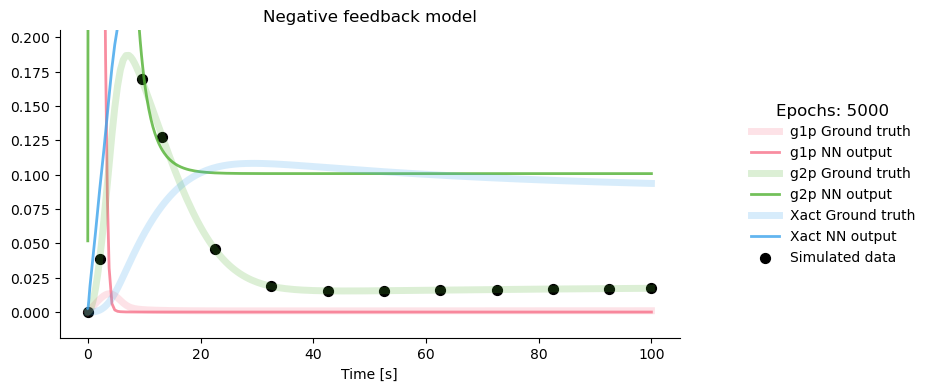

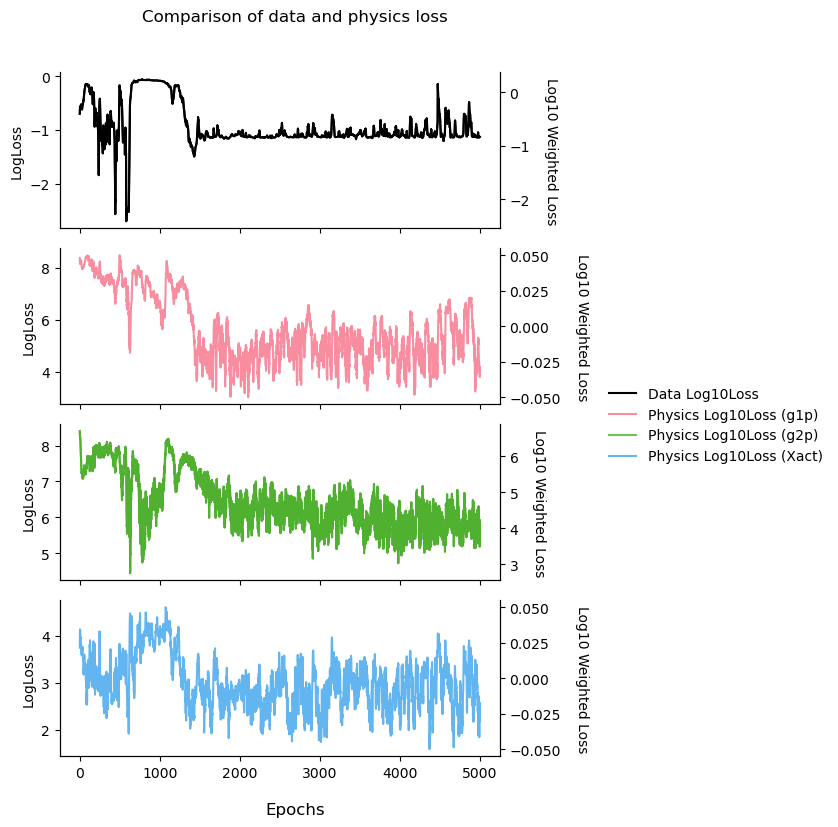

Epoch: 6000
Epoch: 7000
Epoch: 8000
Epoch: 9000
Epoch: 10000


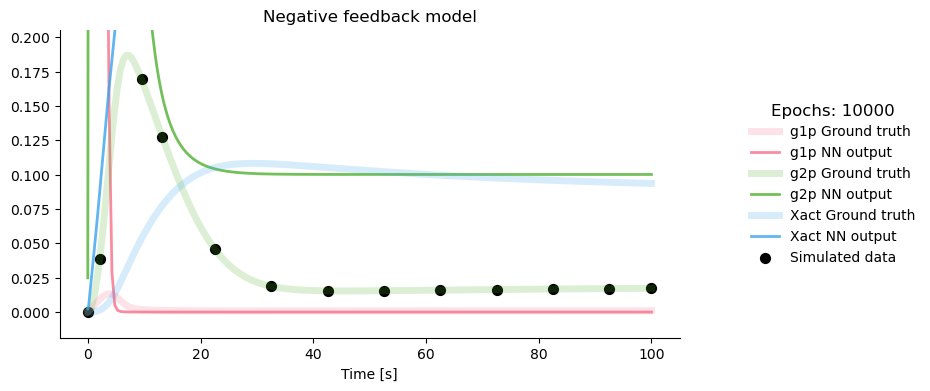

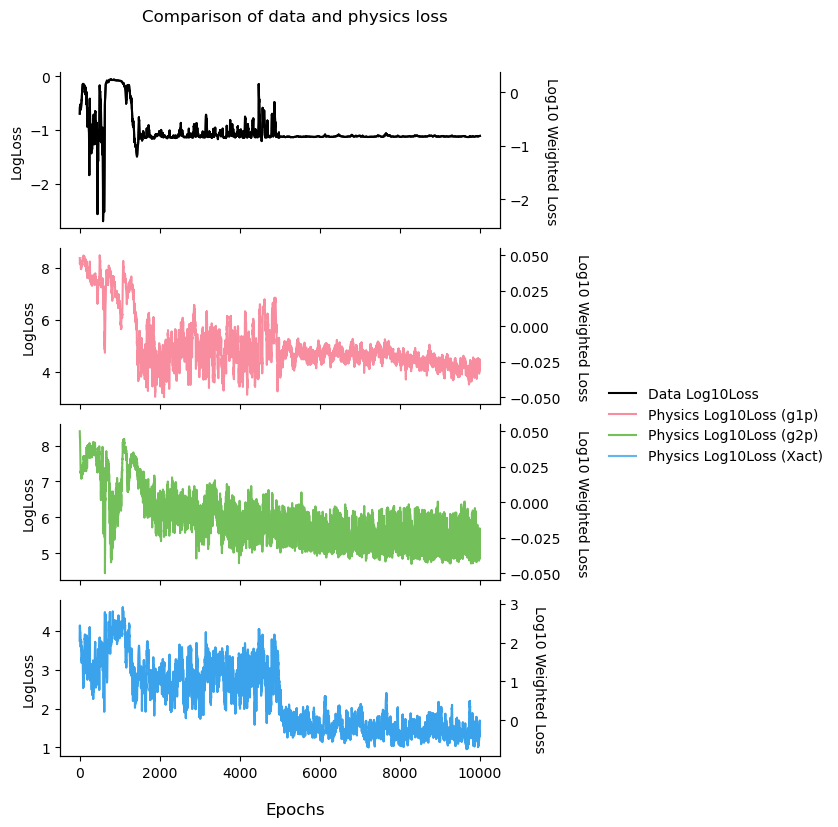

Epoch: 11000
Epoch: 12000
Epoch: 13000
Epoch: 14000
Epoch: 15000


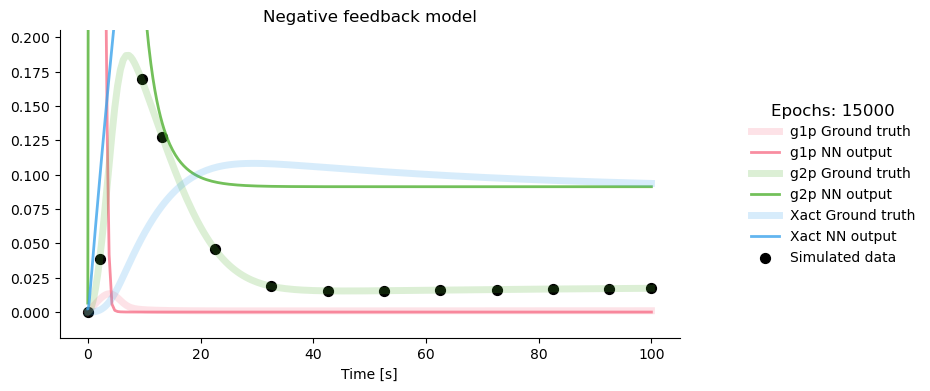

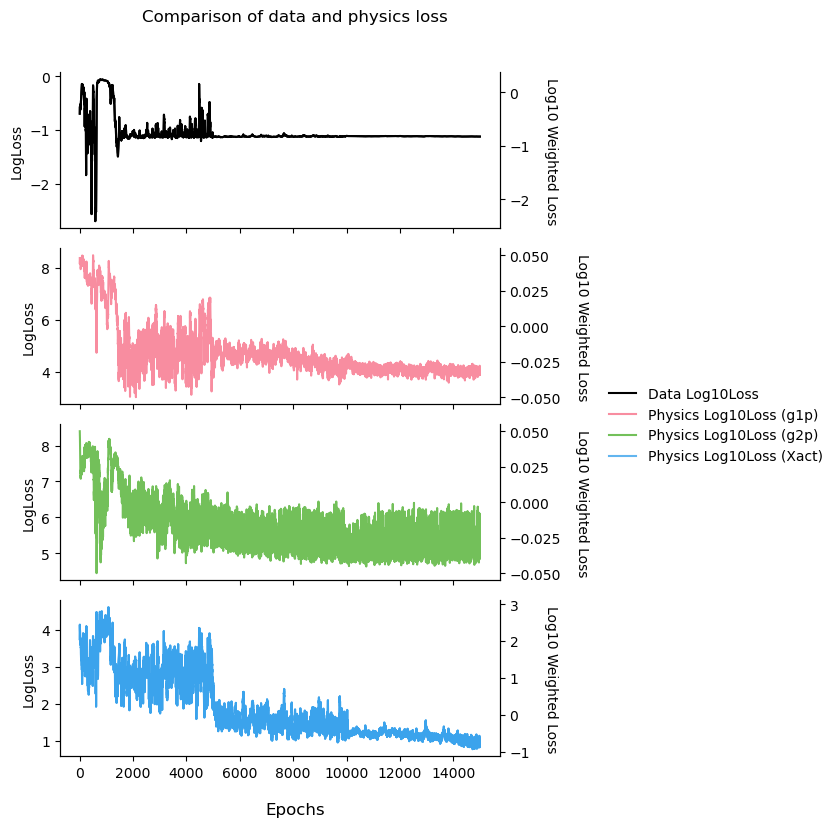

Epoch: 16000
Epoch: 17000
Epoch: 18000
Epoch: 19000
Epoch: 20000


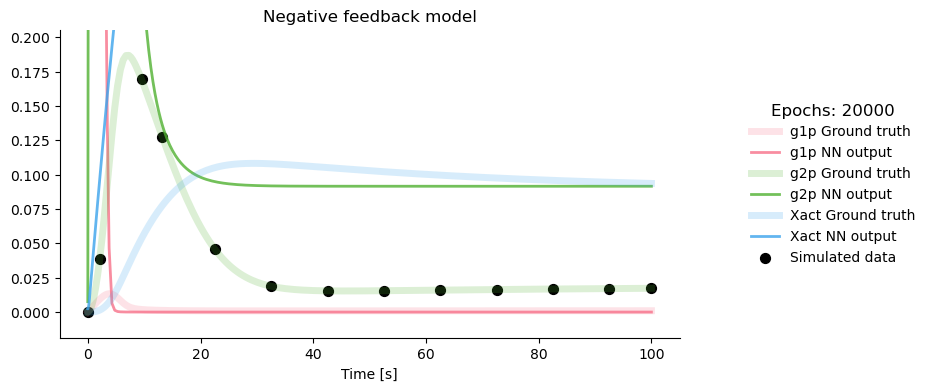

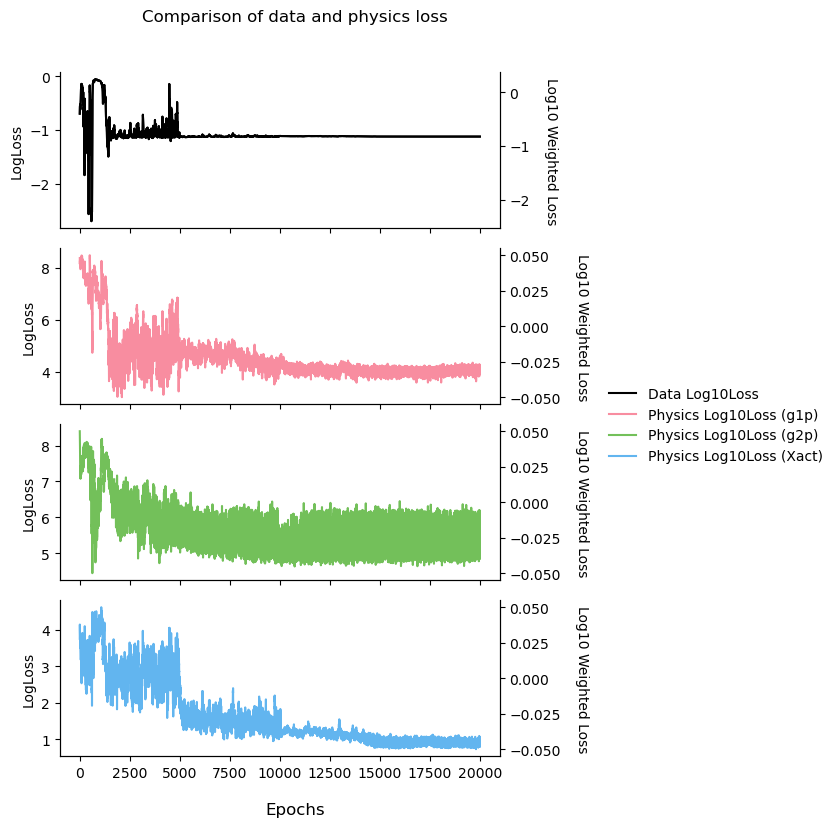

Epoch: 21000
Epoch: 22000
Epoch: 23000
Epoch: 24000
Epoch: 25000


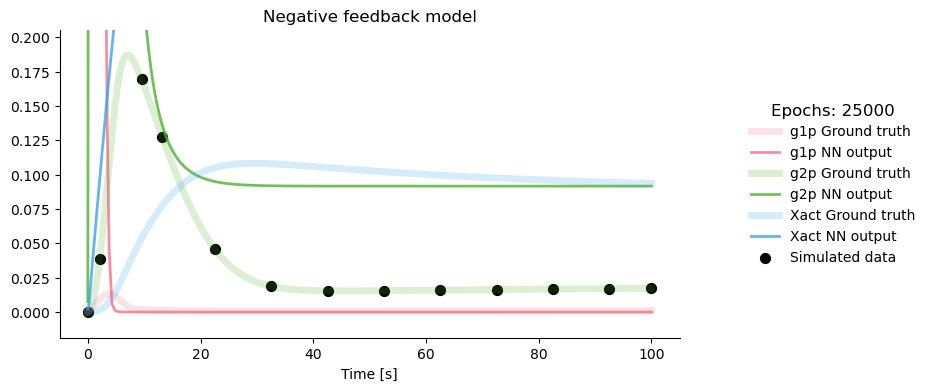

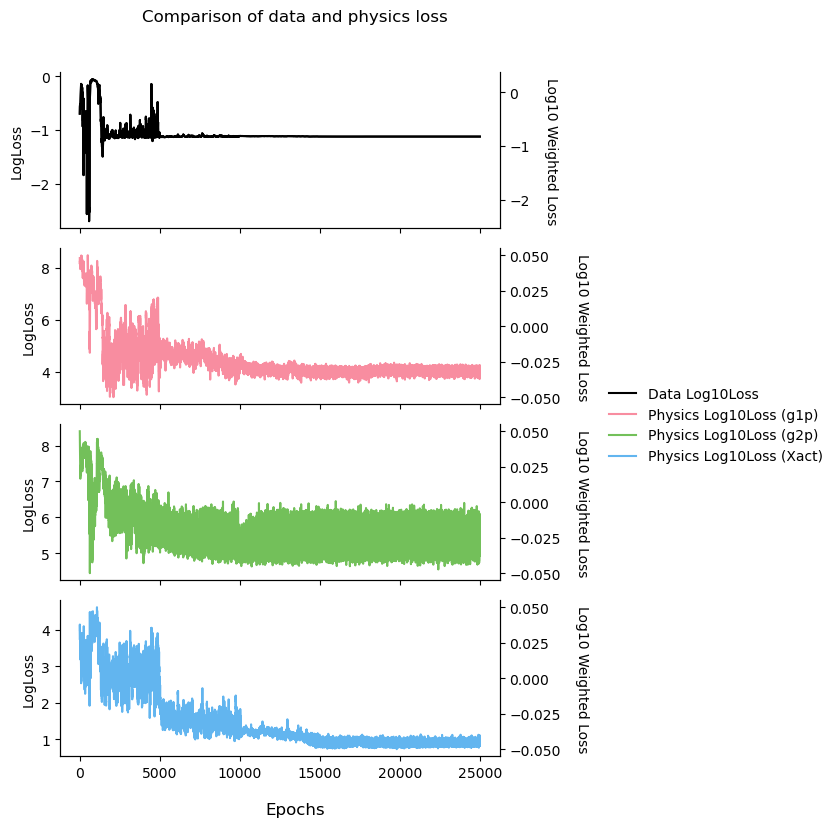

Epoch: 26000
Epoch: 27000
Epoch: 28000
Epoch: 29000
Epoch: 30000


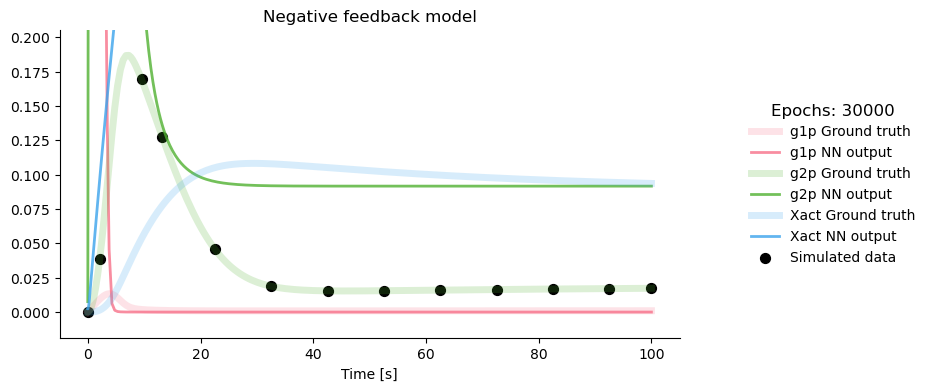

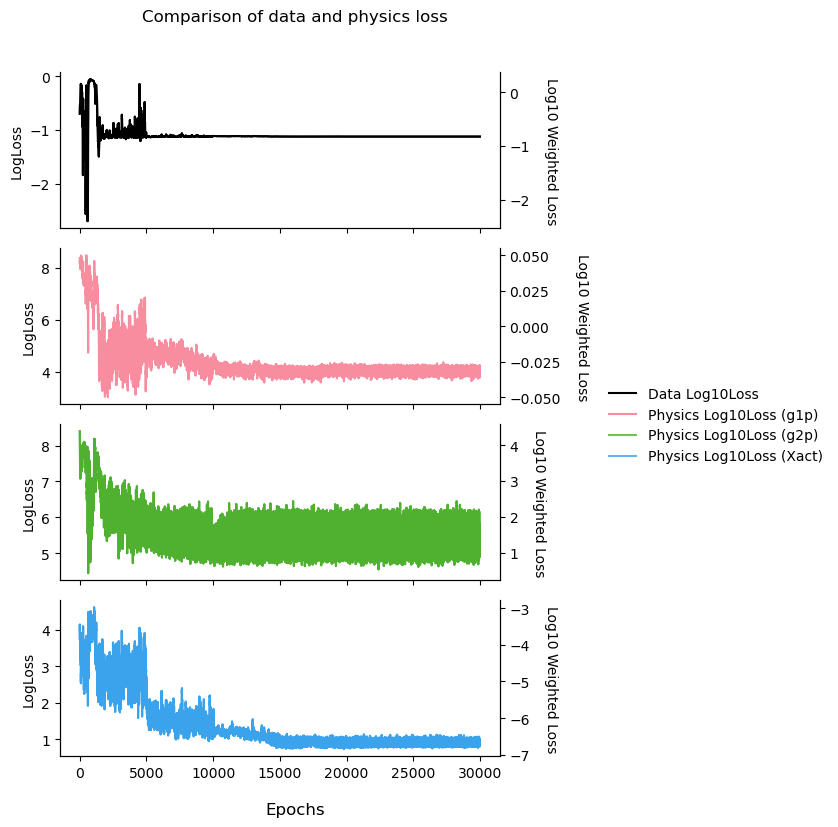

Epoch: 31000
Epoch: 32000
Epoch: 33000
Epoch: 34000
Epoch: 35000


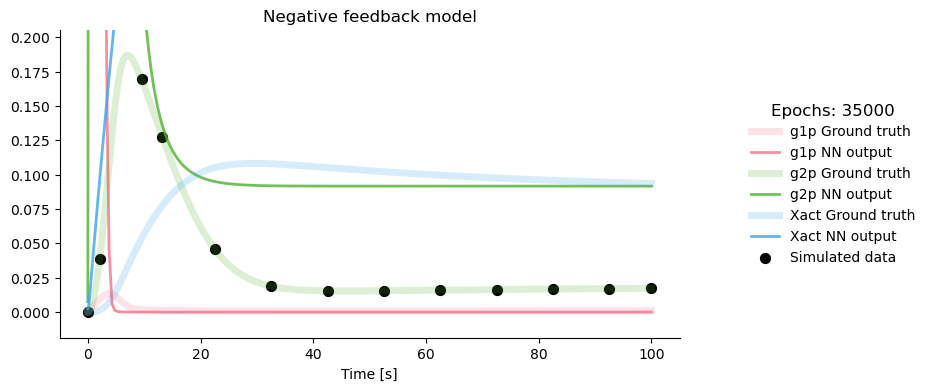

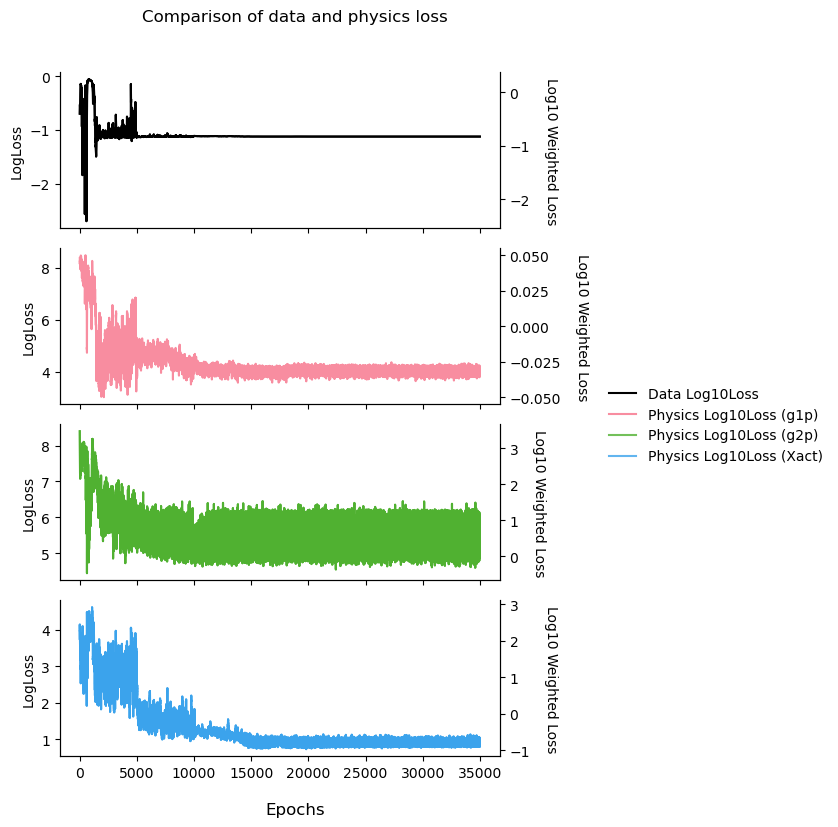

Epoch: 36000
Epoch: 37000
Epoch: 38000
Epoch: 39000
Epoch: 40000


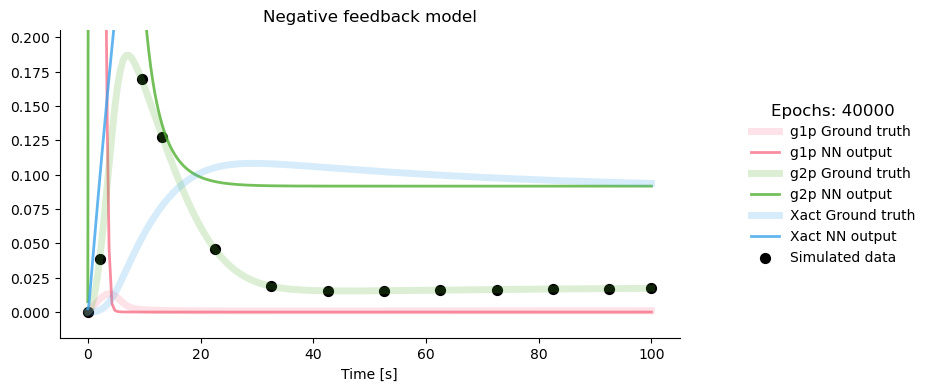

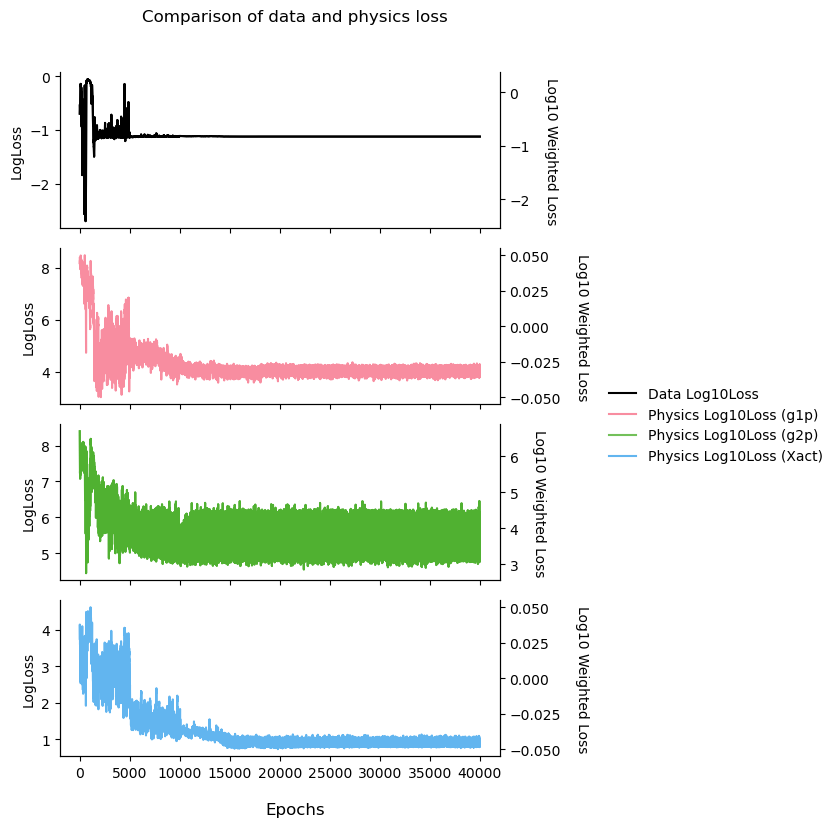

Epoch: 41000
Epoch: 42000
Epoch: 43000
Epoch: 44000
Epoch: 45000


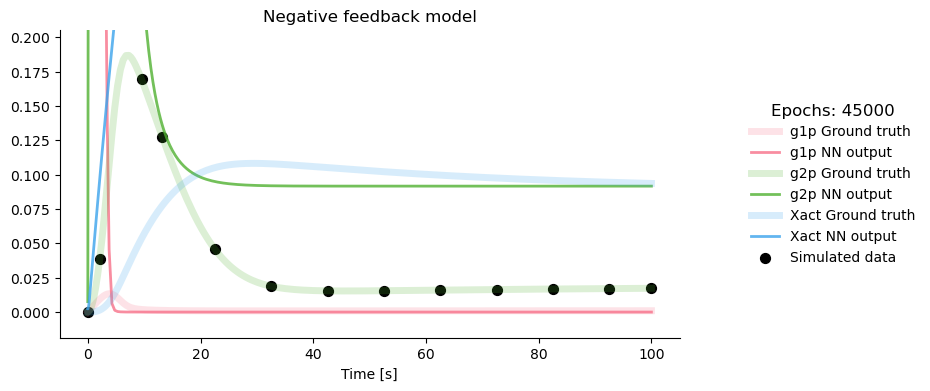

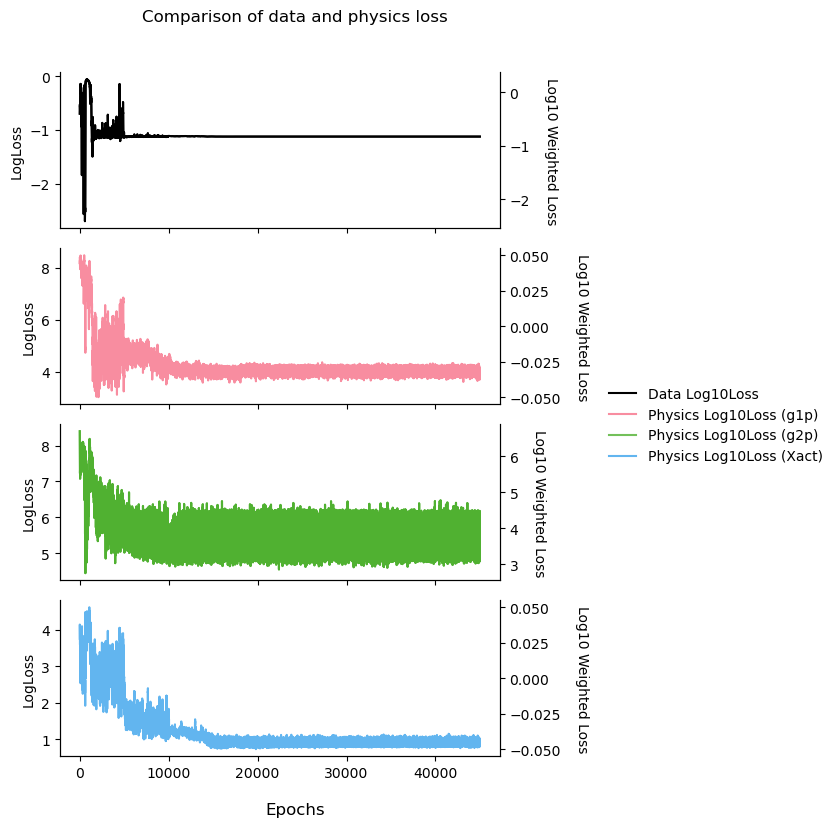

Epoch: 46000
Epoch: 47000
Epoch: 48000
Epoch: 49000
Epoch: 50000


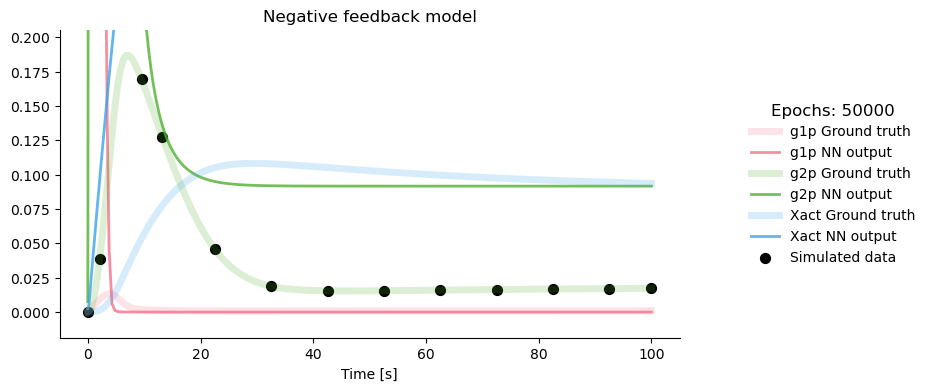

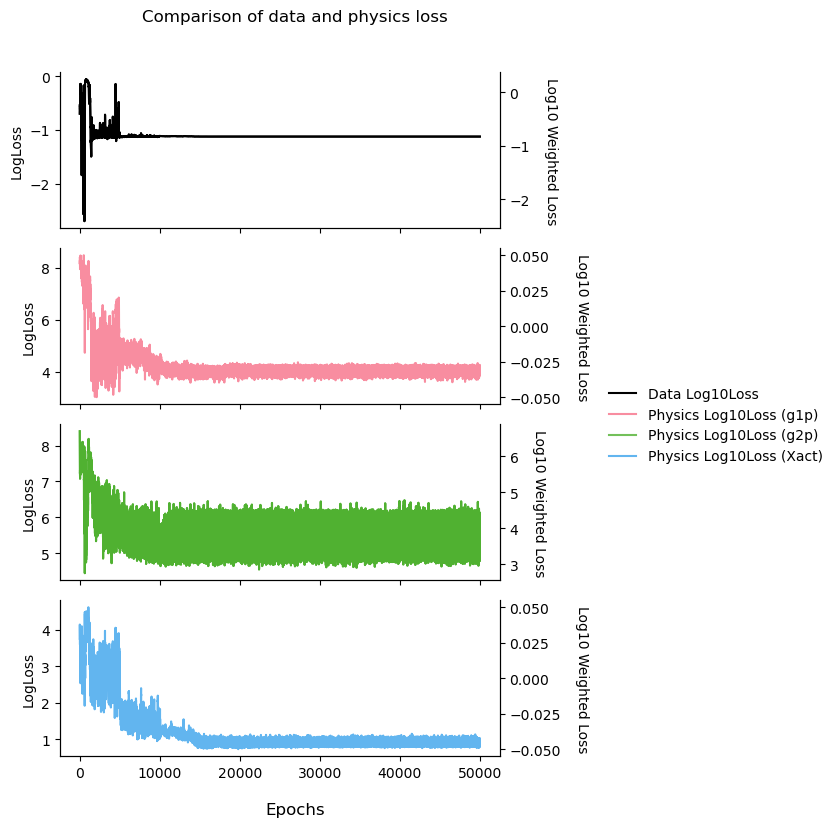

In [37]:
torch.manual_seed(123)

# Network-related parameters
size_batch = 500
size_space = int(1e5)
n_epochs = int(5e4)
early_stop_patience = int(1e5)
lr_patience = int(5e3)

# Plot-related parameters
plot_title= "Negative feedback model"
max_y = torch.max(torch.max(nfb_y, dim=1)[0], dim=0)[0].item()
min_y = torch.min(torch.min(nfb_y, dim=1)[0], dim=0)[0].item()
y_interval = (max_y - min_y)/10
ylim = (min_y-y_interval, max_y+y_interval)
labels = ["g1p", "g2p", "Xact"]

# Select the algorithms to use among RLBL (ReLoBRaLo), LN (Loss Normalisation) and IS (Importance Sampling)
algorithms = ["RLBL"]

# Launch training
model, optim, lr_scheduler, final_epoch, plot_files, losses, weights = train_sbinn(
    nfb_t_data, nfb_y_data[:,1:2], nfb_t, nfb_y, 
    nfb_residuals, nfb_param_a, plot_title=plot_title, ylim=ylim, labels=labels,
    size_batch=size_batch, size_space=size_space, n_epochs=n_epochs,
    early_stop_patience=early_stop_patience, lr_patience=lr_patience, algorithms=algorithms)

##### Train for Protein activation model

In [159]:
size_batch = 200
size_space = int(1e4)
weights = {"Data": 1, "Physics": 1e2, "Gradient": 0}
n_epochs = int(2.5e5)
plot_title= "Protein activation"
max_y = torch.max(prot_activ_y, dim=0)[0].item()
min_y = torch.min(prot_activ_y, dim=0)[0].item()
y_interval = (max_y - min_y)/10
ylim = (min_y-y_interval, max_y+y_interval)
early_stop_patience = 15000
model, plot_files, loss_files, losses = train_sbinn(prot_activ_t_data, prot_activ_y_data, prot_activ_t, prot_activ_y, 
                                            weights, size_batch, size_space, n_epochs,
                                            prot_activation_residuals, prot_activ_param, plot_title, ylim,
                                            early_stop_patience)

TypeError: object of type 'float' has no len()

## Plotting and Saving

In [38]:
# Enter name to save model and plots
model_name = "nfba_13_data_g2p_500samples_3d_16w_relobralo_T1e-3_p1_a099_5e4" 

In [39]:
# Save animation of the training
save_video("./Models/"+model_name+"_pinn.mp4", plot_files, fps=10, delete=True)

/var/folders/_t/ync8_qqd0x17ctlhlgz_qj580000gn/T/ipykernel_26536/2618191715.py:17: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(loss*weights[name][j].cpu().item()), color=palette[j])


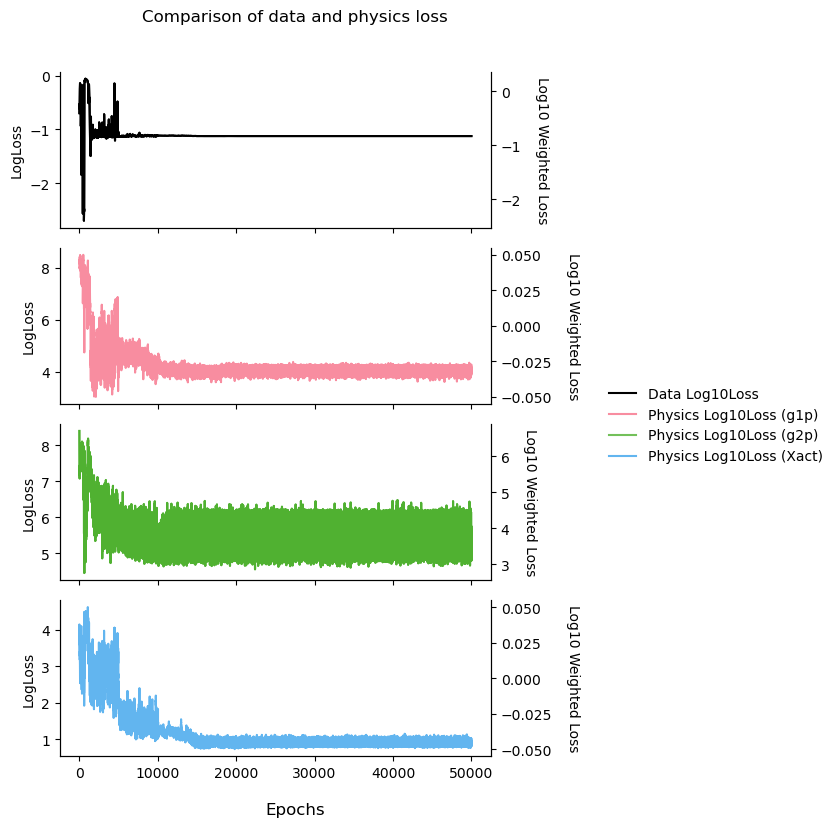

In [40]:
# Save plot of the loss
plot_losses(losses, weights, filename="./Models/"+model_name+"_loss.svg", labels=labels)

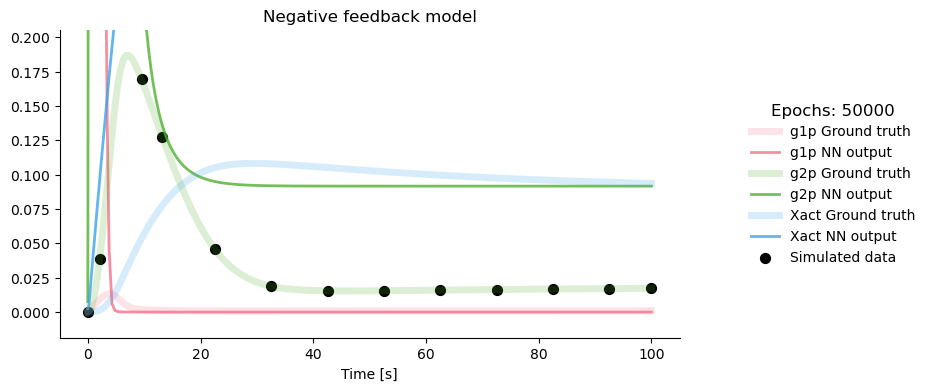

In [41]:
# Save prediction plot after training
model.eval()
yh = model(nfb_t).detach()
plot_training_result(nfb_t, nfb_y, nfb_t_data, nfb_y_data[:,1:2], yh, final_epoch, title=plot_title, ylim=ylim, labels=labels)
plt.savefig(f"./Models/{model_name}_pred.svg", bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [181]:
# Save the model parameters
torch.save(
    {'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'final_epoch': final_epoch,
     'lr_scheduler': lr_scheduler,
     'early_stopping_patience': early_stop_patience,
     'algorithms': algorithms
}, "./Models/"+model_name+".pth")

##### Loading saved models

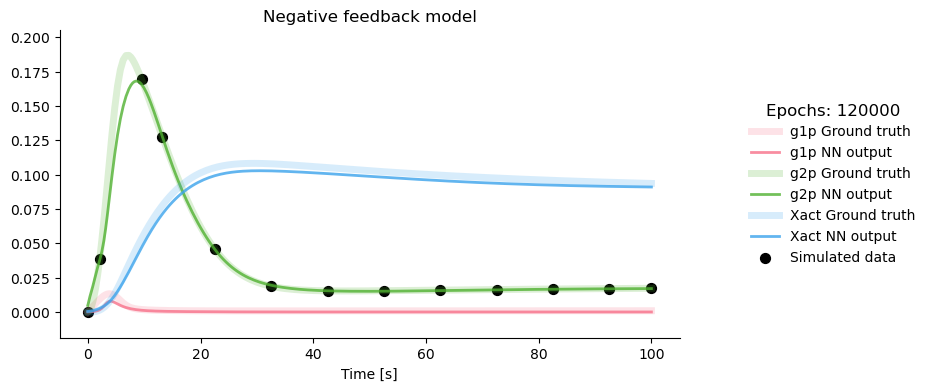

In [153]:
# Load saved model
filename = "./Models/nfba_20_data_g2p_500samples_3d_16w_1000loss_dystd.pth"
model_info = torch.load(filename)
saved_model = FFN(1, nfb_y.size(1), 16, 3)
saved_model.load_state_dict(model_info["model_state_dict"])
saved_model.eval()
yh = saved_model(nfb_t).detach()
plot_training_result(nfb_t, nfb_y, nfb_t_data, nfb_y_data[:,1:2], yh, 
                     model_info["final_epoch"], title=plot_title, ylim=ylim, labels=labels)
plot_filename = "./Plots/nfba_13_data_g2p_500samples_3d_16w_wd1_wp1e-8_1e-10_1e-6_pred.svg"
#plt.savefig(plot_filename, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [151]:
model_info

OrderedDict([('fcs.0.weight',
              tensor([[ 0.4797],
                      [ 0.1957],
                      [ 0.3425],
                      [-0.2076],
                      [-0.0866],
                      [ 0.0686],
                      [ 1.1510],
                      [-2.7891],
                      [ 4.4533],
                      [ 0.4521],
                      [-0.0266],
                      [ 0.9897],
                      [-0.2644],
                      [-0.0753],
                      [ 1.1286],
                      [ 0.9327]])),
             ('fcs.0.bias',
              tensor([ 0.8585,  2.7836,  2.8835,  0.2441, -2.1509,  1.0250,  0.8570, -1.1088,
                       0.6258,  2.5859,  0.3889,  4.9186, -0.2435, -2.6354,  1.4927,  2.1446])),
             ('fch.0.0.weight',
              tensor([[ 1.5150e+00,  7.7113e-01,  3.2783e+00,  3.1565e-01, -4.6513e-01,
                       -2.8625e+00,  2.9817e-01,  6.7801e-01,  8.2696e-01,  1.6180e+00,
            